In [1]:
%load_ext autoreload
%autoreload 2
import sys

import pandas as pd

sys.path.append("../..")

from mlstm_kernels.utils.benchmark.plot_results import (
    plot_benchmark_result_table,
    rc_context_wrapper,
    select_columns,
)
from pathlib import Path
from plot_config import linestyle_mapping, style_dict
import pickle

In [2]:
# Collect all results batch size 1
falconmamba_gen_len_1_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_14-24-09__ttft__timetofirsttoken_gencudagraph_falconmamba_v0/hf_7B_timtofirsttok__bs1_gl1_tcTrue_weightdtypebfloat16/results.csv"
falconmamba_gen_len_100_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_14-24-09__ttft__timetofirsttoken_gencudagraph_falconmamba_v0/hf_7B_timtofirsttok__bs1_gl101_tcTrue_weightdtypebfloat16/results.csv"

codestralmamba_gen_len_1_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_14-35-21__ttft__timetofirsttoken_gencudagraph_codestralmamba_v0/hf_7B_timtofirsttok__bs1_gl1_tcTrue_weightdtypebfloat16/results.csv"
codestralmamba_gen_len_100_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_14-35-21__ttft__timetofirsttoken_gencudagraph_codestralmamba_v0/hf_7B_timtofirsttok__bs1_gl101_tcTrue_weightdtypebfloat16/results.csv"

mxlstmmamba_gen_len_1_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_15-43-57__ttft__timetofirsttoken_gencudagraph_xmlstm_v0/hf_7B_timtofirsttok__bs1_gl1_tcTrue_weightdtypebfloat16/results.csv"
mxlstmmamba_gen_len_100_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_15-43-57__ttft__timetofirsttoken_gencudagraph_xmlstm_v0/hf_7B_timtofirsttok__bs1_gl101_tcTrue_weightdtypebfloat16/results.csv"

llama_gen_len_1_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_15-48-51__ttft__timetofirsttoken_gencudagraph_llama_v0/hf_7B_timtofirsttok__bs1_gl1_tcFalse_weightdtypebfloat16/results.csv"
llama_gen_len_100_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-04_15-48-51__ttft__timetofirsttoken_gencudagraph_llama_v0/hf_7B_timtofirsttok__bs1_gl101_tcFalse_weightdtypebfloat16/results.csv"

llama_static_gen_len_1_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-05_15-14-03__ttft__llama_static_cache_v0/hf_7B_timtofirsttok__bs1_gl1_tcTrue_weightdtypebfloat16/results.csv"
llama_static_gen_len_100_file = "/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-05_15-14-03__ttft__llama_static_cache_v0/hf_7B_timtofirsttok__bs1_gl101_tcTrue_weightdtypebfloat16/results.csv"

file_dict = {
    "falconmamba": (falconmamba_gen_len_1_file, falconmamba_gen_len_100_file),
    "codestralmamba": (codestralmamba_gen_len_1_file, codestralmamba_gen_len_100_file),
    "mxlstmmamba": (mxlstmmamba_gen_len_1_file, mxlstmmamba_gen_len_100_file),
    "llama": (llama_gen_len_1_file, llama_gen_len_100_file),
    "llama_static": (llama_static_gen_len_1_file, llama_static_gen_len_100_file),
}

In [3]:
def load_timetofirst_token_results(gen_len_1_file, gen_len_100_file):
    gen_len_1_df = pd.read_csv(gen_len_1_file).filter(regex=".*(prefill|R--.*).*")
    gen_len_100_df = pd.read_csv(gen_len_100_file).filter(regex=".*(prefill|R--.*).*")
    tok_per_sec_data_df = 100 / (
        (gen_len_100_df.filter(regex=".*R--.*") - gen_len_1_df.filter(regex=".*R--.*"))
        / 1000
    )
    tok_per_sec_df = pd.concat(
        [gen_len_1_df.filter(regex=".*prefill.*"), tok_per_sec_data_df], axis=1
    )
    return tok_per_sec_df, gen_len_1_df, gen_len_100_df

In [4]:
dataframe_dict = {k: load_timetofirst_token_results(*v) for k, v in file_dict.items()}

In [5]:
token_per_sec_df = pd.concat([v[0] for v in dataframe_dict.values()], axis=1)
token_per_sec_df = pd.concat(
    [
        token_per_sec_df.filter(regex=".*prefill.*").take([0], axis=1),
        token_per_sec_df.filter(regex=".*R--.*"),
    ],
    axis=1,
)
token_per_sec_df

,P--prefill_length,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,128,87.357737,27.673853,102.701980,37.383194,157.349769,155.472090,136.542074,141.370073,108.216187,103.618792,65.209558,60.796995,147.617183,135.918167
1,512,87.236267,28.086773,102.860096,37.073048,157.230533,155.652820,133.336738,142.881921,97.430578,94.001524,65.864979,61.209240,138.573900,124.827110
2,1024,87.266587,28.135969,102.569881,37.295135,157.129789,155.845096,136.164099,142.723905,86.131399,83.874872,66.018598,60.587984,126.470905,113.620011
3,2048,87.355957,28.133680,102.766300,37.323086,157.367095,155.744724,136.677577,142.618806,70.488404,69.873956,62.707995,61.907811,109.353050,97.724146
4,4096,87.205324,28.223977,103.146068,37.370230,157.334284,155.512207,137.970256,142.410743,51.527760,52.248173,47.382893,47.763444,85.886549,76.780089
5,8192,87.278175,28.322812,103.141799,36.442576,157.441801,155.317403,131.760106,142.429483,33.670100,34.337783,31.793542,32.114967,60.320708,52.974091
6,16384,87.308302,28.083084,103.736448,37.488965,157.540285,156.019614,135.673674,141.964164,20.003801,20.762012,19.309571,19.792552,37.145707,32.265035


In [6]:
ttft_1_df = pd.concat([v[1] for v in dataframe_dict.values()], axis=1)
ttft_1_df = pd.concat(
    [
        ttft_1_df.filter(regex=".*prefill.*").take([0], axis=1),
        ttft_1_df.filter(regex=".*R--.*"),
    ],
    axis=1,
)
ttft_1_df

,P--prefill_length,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,128,20.039512,44.277984,14.955208,69.519584,8.678552,8.601328,27.792521,17.470632,11.368560,11.920264,24.585999,21.267440,8.155448,8.744840
1,512,36.300992,45.462567,27.353880,67.089063,14.418112,14.640408,22.131240,23.914024,19.544592,20.043840,25.114264,27.375528,13.827392,14.742128
2,1024,59.413745,66.726376,50.210505,58.882433,25.212024,26.383728,32.205585,34.443192,33.688816,35.105168,38.809040,39.654176,24.963056,27.253904
3,2048,115.203840,122.570545,100.511951,107.877560,46.095297,50.183320,52.075458,55.320648,73.962456,74.096720,77.864815,77.718287,56.216432,57.648120
4,4096,217.650494,227.948734,194.115440,198.100418,89.301018,98.330942,95.717634,103.420105,163.313396,167.970581,165.895664,168.530750,128.345903,133.445831
5,8192,447.924156,455.320915,385.449921,390.310234,178.773346,196.161938,185.833706,203.769817,398.896484,405.430801,405.577911,406.276993,333.687737,341.715103
6,16384,891.464081,904.974380,774.263962,784.629181,348.930519,394.782242,357.148605,400.783157,1095.705109,1108.238678,1106.036224,1114.165741,976.108124,993.804276


In [7]:
ttft_100_df = pd.concat([v[2] for v in dataframe_dict.values()], axis=1)
ttft_100_df = pd.concat(
    [
        ttft_100_df.filter(regex=".*prefill.*").take([0], axis=1),
        ttft_100_df.filter(regex=".*R--.*"),
    ],
    axis=1,
)
ttft_100_df

,P--prefill_length,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--mlstm_simple__tcm__ampdt-bfloat16__wdt-bfloat16__utcg-False_ucgg-False_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama2__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama3__ampdt-bfloat16__wdt-bfloat16__ucgg-False_ucgm-False,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,128,1164.757812,3657.797180,988.646271,2744.518433,644.205383,651.803589,760.167511,724.833923,935.444733,976.996170,1558.103516,1666.085571,685.583359,744.481659
1,512,1182.613220,3605.857300,999.548187,2764.466431,650.426895,657.095840,772.112091,723.792633,1045.916412,1083.856384,1543.371796,1661.115784,735.464005,815.850159
2,1024,1205.327698,3620.895752,1025.155579,2740.197266,661.628586,668.046524,766.613556,735.096664,1194.705597,1227.357361,1553.533722,1690.146454,815.658752,907.380554
3,2048,1259.945465,3677.029053,1073.593597,2787.184387,681.552155,692.259644,783.724365,756.490448,1492.635529,1505.245117,1672.557800,1693.023346,970.685669,1080.936676
4,4096,1364.369476,3771.035583,1163.614349,2874.027222,724.890396,741.367279,820.511536,805.614319,2104.014893,2081.913086,2276.362000,2262.182129,1292.672577,1435.866821
5,8192,1593.685974,3986.043762,1354.988953,3134.353333,813.928680,840.004791,944.788773,905.871643,3368.890625,3317.674744,3550.870728,3520.089905,1991.493225,2229.430359
6,16384,2036.830536,4465.836914,1738.245300,3452.080811,983.688797,1035.727295,1094.211273,1105.186279,6094.755005,5924.727661,6284.815186,6166.571289,3668.209229,4093.134583


In [8]:
raw_data = {
    "token_per_sec": token_per_sec_df,
    "ttft_1": ttft_1_df,
    "ttft_100": ttft_100_df,
}
with open("ttft_raw_data.p", "wb") as f:
    pickle.dump(raw_data, f)

In [9]:
for k, v in raw_data.items():
    v.to_csv(f"raw_data_ttft_{k}.csv")

In [10]:
with open("ttft_raw_data.p", "rb") as f:
    raw_data = pickle.load(f)

ttft_1_df = raw_data["ttft_1"]
ttft_100_df = raw_data["ttft_100"]
token_per_sec_df = raw_data["token_per_sec"]

## Plotting the raw data

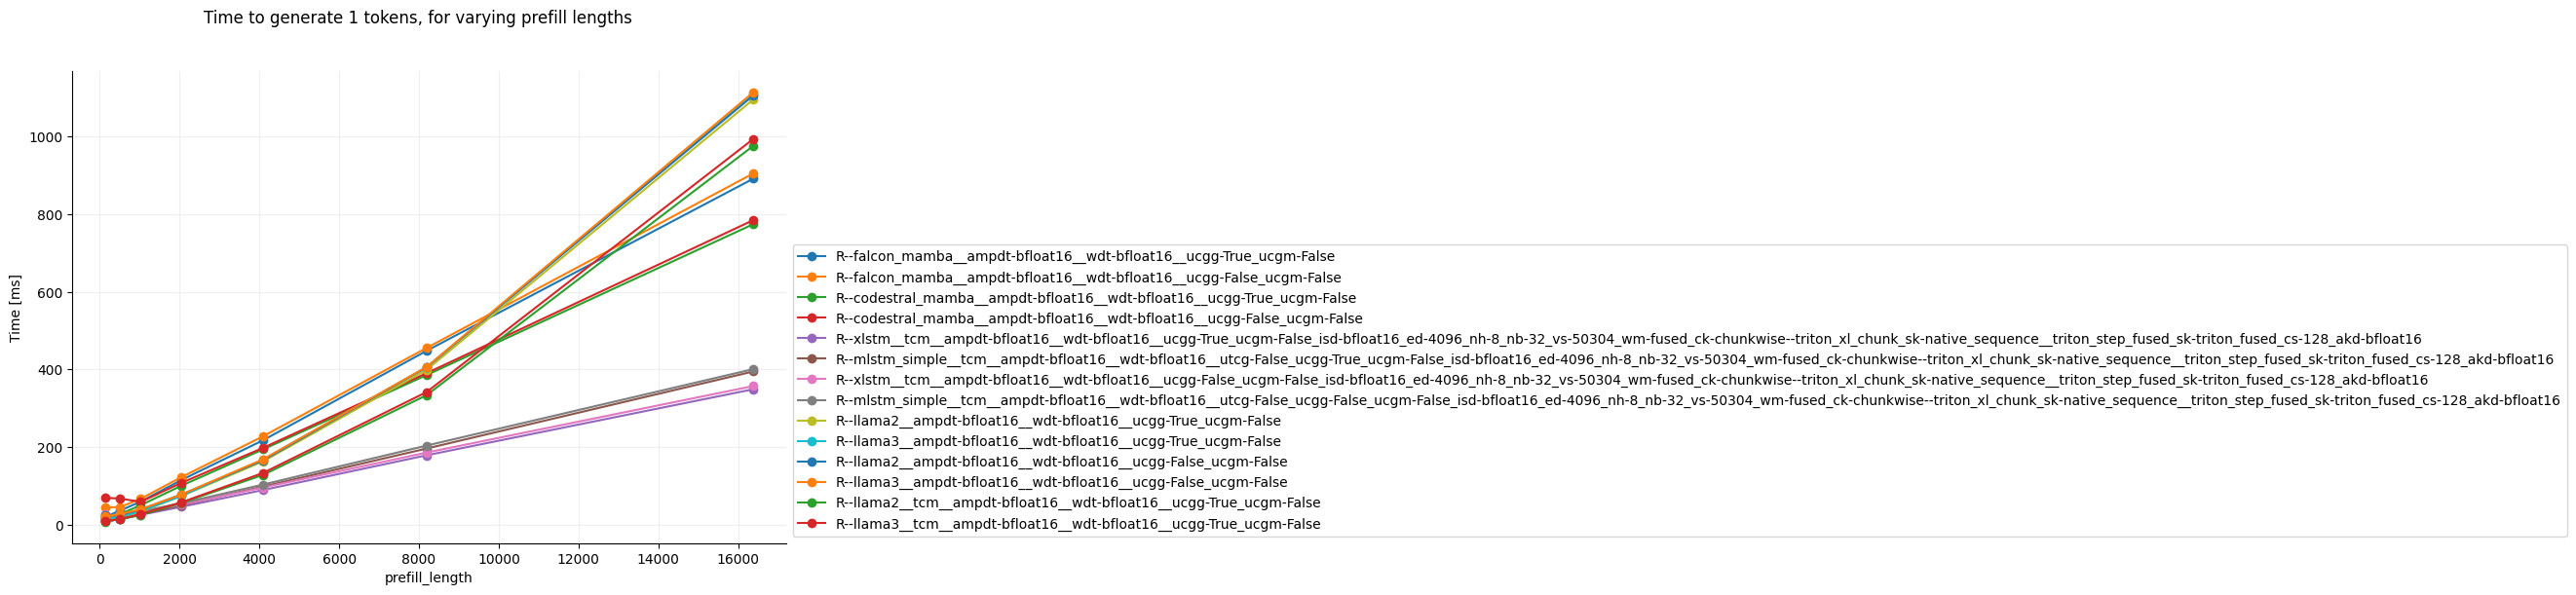

In [11]:
fig = plot_benchmark_result_table(
    ttft_1_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time [ms]",
    title="Time to generate 1 tokens, for varying prefill lengths",
)

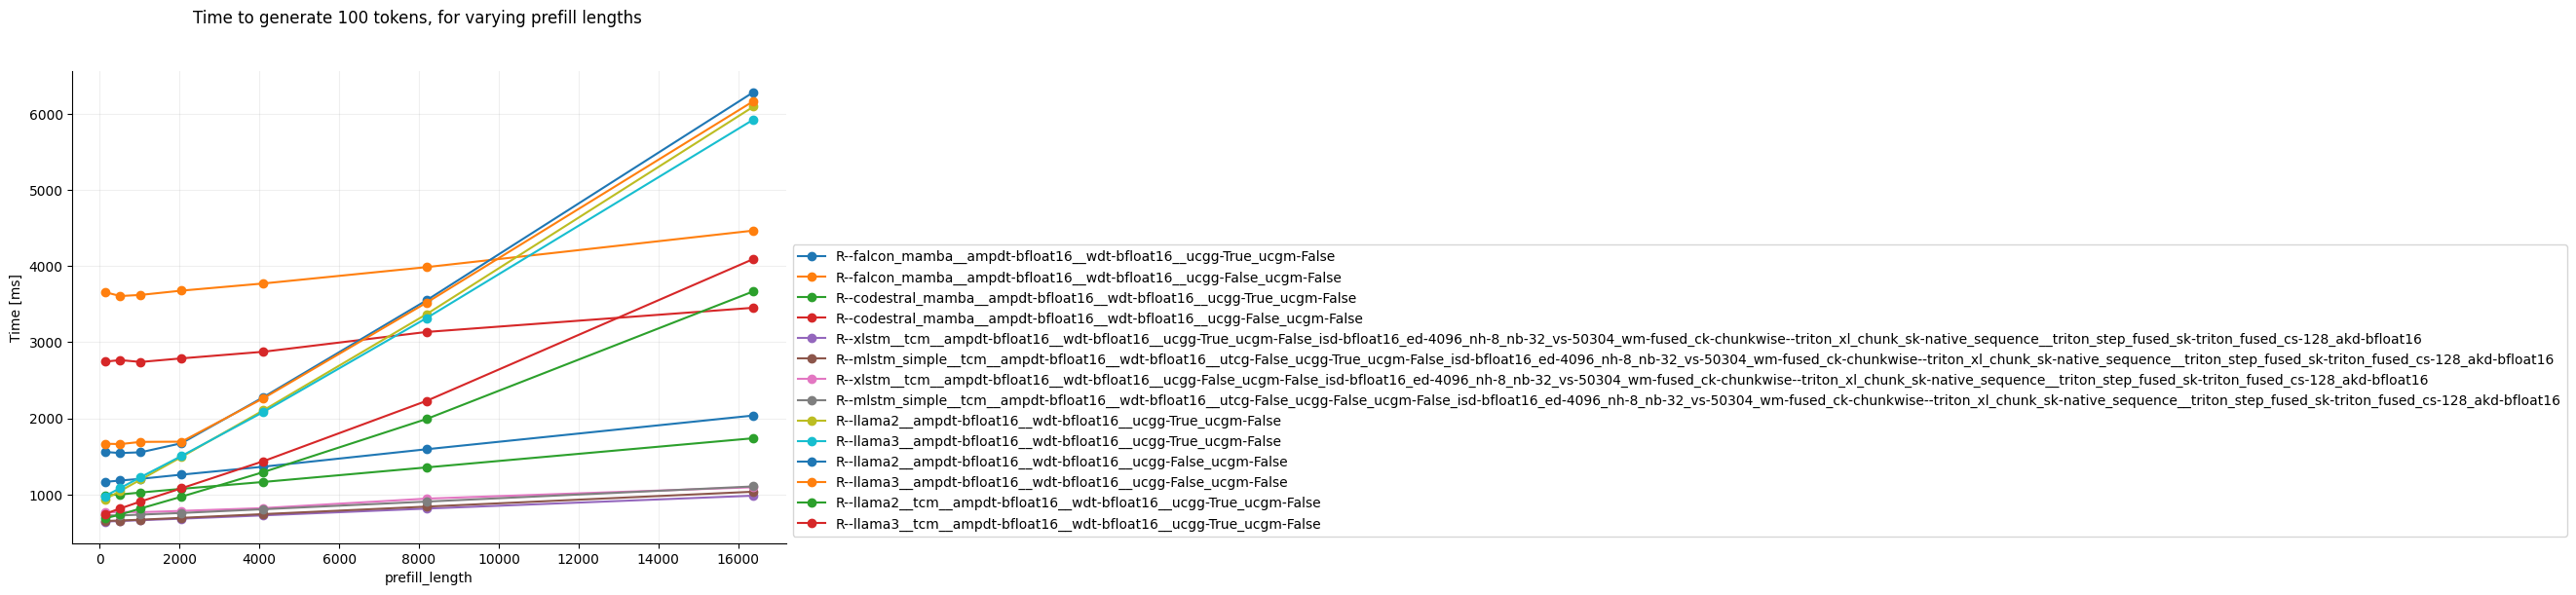

In [12]:
fig = plot_benchmark_result_table(
    ttft_100_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time [ms]",
    title="Time to generate 100 tokens, for varying prefill lengths",
)

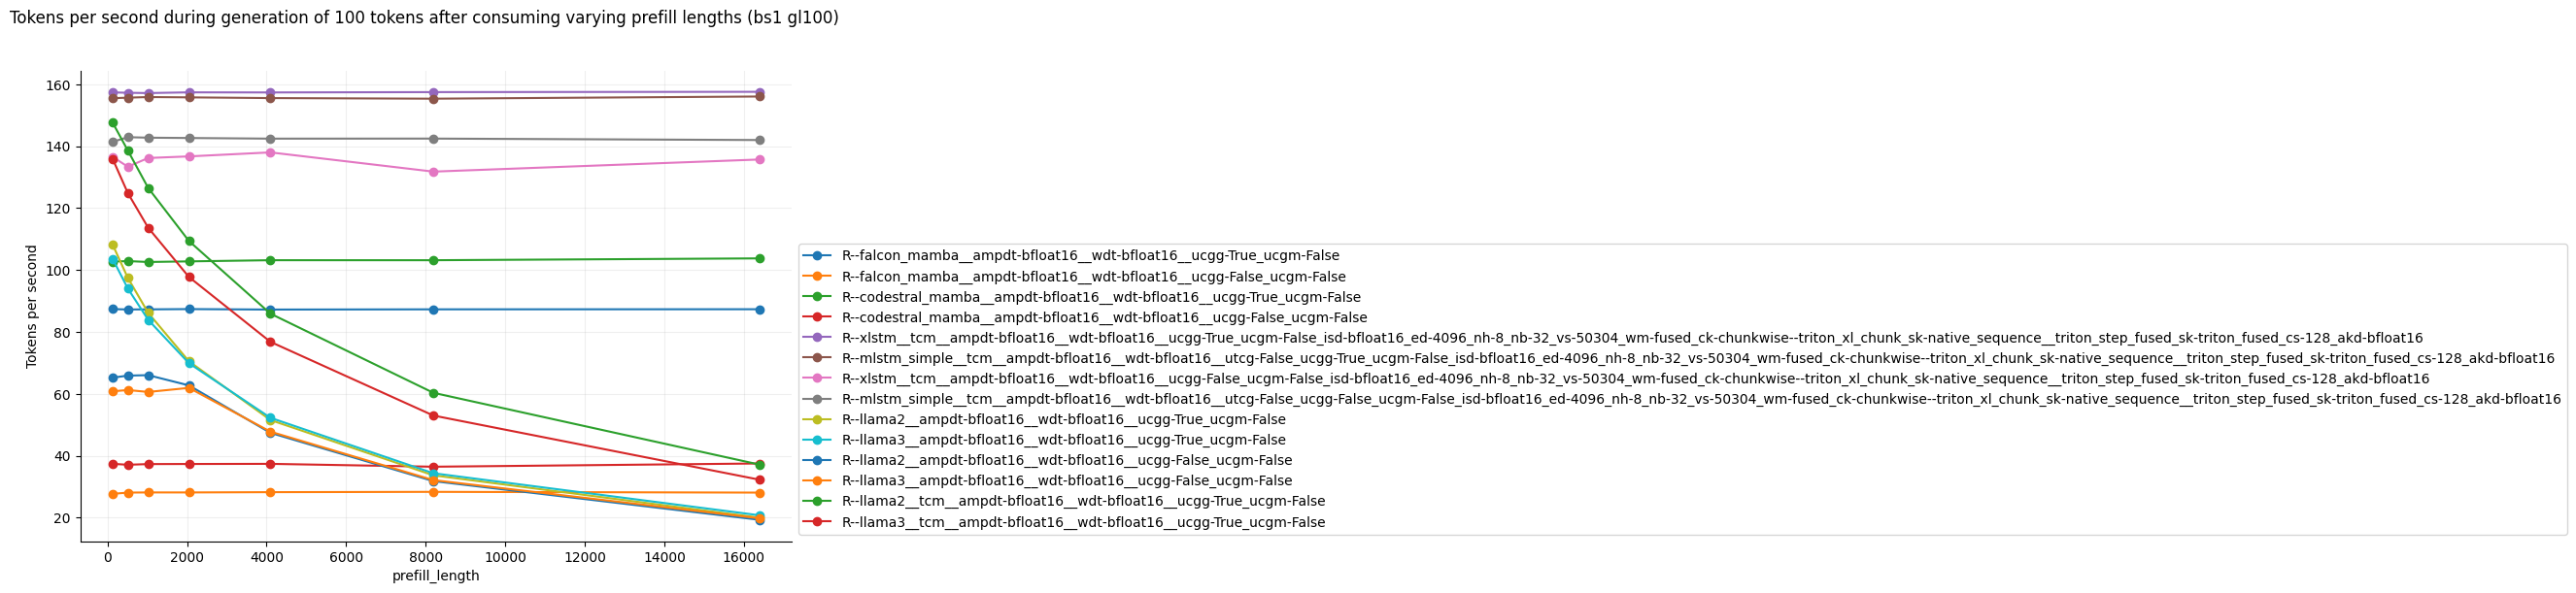

In [13]:
fig = plot_benchmark_result_table(
    token_per_sec_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    # style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Tokens per second",
    title="Tokens per second during generation of 100 tokens after consuming varying prefill lengths (bs1 gl100)",
)

## Final Plots - All results

In [14]:
selected_columns = {
    "llama3": "R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
    "llama2": "R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
    "falcon_mamba": "R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
    "codestral_mamba": "R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
    "xlstm": "R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16",
}
filename_suffix = ""
add_legend = True

In [15]:
ttft_1_plot_df = select_columns(
    ttft_1_df, selected_columns, keep_col_regex=".*prefill.*"
)

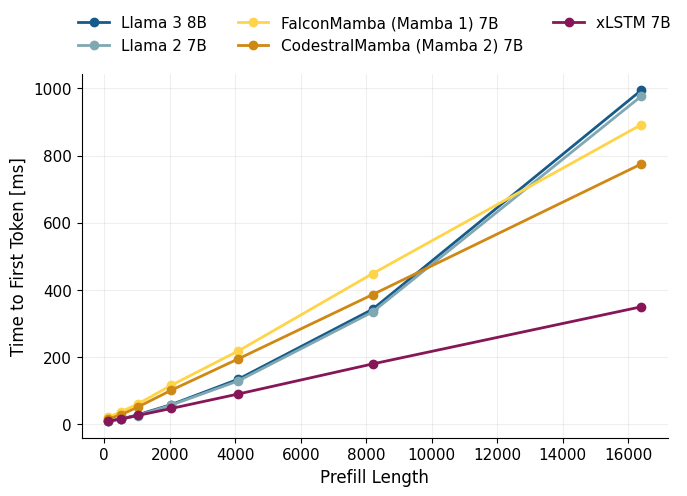

In [16]:
fig = rc_context_wrapper(
    func=plot_benchmark_result_table,
    result_df=ttft_1_plot_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time to First Token [ms]",
    x_label="Prefill Length",
    title="",  # "Time to generate 1 tokens, for varying prefill lengths",
    figsize=(1.6 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    filename=f"timetofirsttoken_1_tokens{filename_suffix}",
    add_legend=add_legend,
    legend_args={
        "loc": "lower center",
        "ncol": 3,
        "bbox_to_anchor": (0.0, 1.02, 1.0, 0.502),
        "frameon": False,
        "facecolor": "white",
    },
)

In [17]:
ttft_100_plot_df = select_columns(
    ttft_100_df, selected_columns, keep_col_regex=".*prefill.*"
)

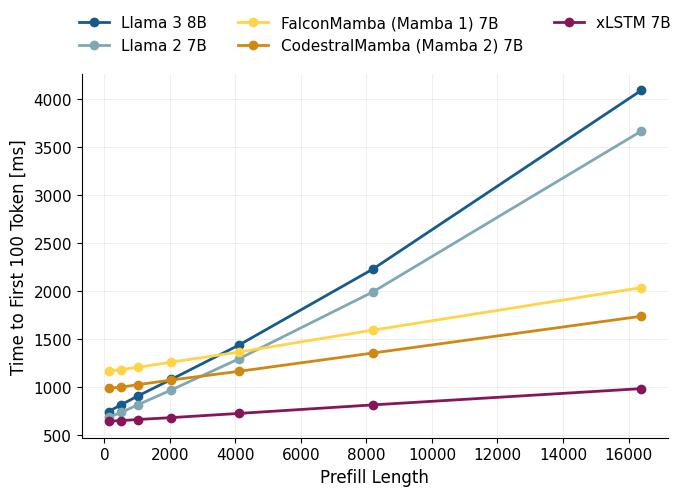

In [18]:
fig = rc_context_wrapper(
    func=plot_benchmark_result_table,
    result_df=ttft_100_plot_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Time to First 100 Token [ms]",
    x_label="Prefill Length",
    title="",  # "Time to generate 100 tokens, for varying prefill lengths",
    figsize=(1.6 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    filename=f"timetofirsttoken_100_tokens_prefill_length{filename_suffix}",
    add_legend=add_legend,
    legend_args={
        "loc": "lower center",
        "ncol": 3,
        "bbox_to_anchor": (0.0, 1.02, 1.0, 0.502),
        "frameon": False,
        "facecolor": "white",
    },
)

In [19]:
token_per_sec_plot_df = select_columns(
    token_per_sec_df, selected_columns, keep_col_regex=".*prefill.*"
)

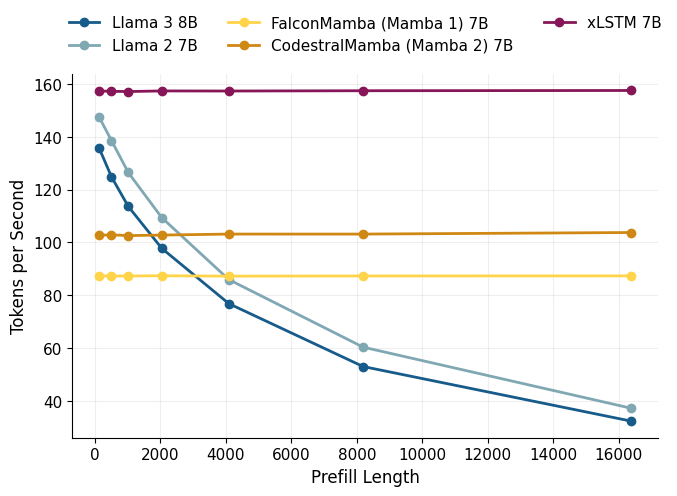

In [20]:
fig = rc_context_wrapper(
    func=plot_benchmark_result_table,
    result_df=token_per_sec_plot_df,
    x_axis_param="prefill_length",
    # linestyle_mapping=linestyle_mapping,
    style_dict=style_dict,
    style_dict_colname_mapping_exact=False,
    y_label="Tokens per Second",
    title="",  # "Tokens per second during generation of 100 tokens after consuming varying prefill lengths (bs1 gl100)",
    x_label="Prefill Length",
    figsize=(1.6 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    filename=f"timetofirsttoken_tokens_per_sec{filename_suffix}",
    add_legend=add_legend,
    legend_args={
        "loc": "lower center",
        "ncol": 3,
        "bbox_to_anchor": (0.0, 1.02, 1.0, 0.502),
        "frameon": False,
        "facecolor": "white",
    },
)

In [21]:
# selected_columns = {
#     "llama3": "R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
#     # "llama2": "R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
#     # "falcon_mamba": "R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
#     "codestral_mamba": "R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False",
#     "xlstm": "R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16",
# }
# filename_suffix = "only_3"

In [22]:
# ttft_1_plot_df = select_columns(
#     ttft_1_df, selected_columns, keep_col_regex=".*prefill.*"
# )

In [23]:
# fig = rc_context_wrapper(
#     func=plot_benchmark_result_table,
#     result_df=ttft_1_plot_df,
#     x_axis_param="prefill_length",
#     # linestyle_mapping=linestyle_mapping,
#     style_dict=style_dict,
#     style_dict_colname_mapping_exact=False,
#     y_label="Time to First Token [ms]",
#     x_label="Prefill Length",
#     title="",  # "Time to generate 1 tokens, for varying prefill lengths",
#     figsize=(1.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
#     filename=f"timetofirsttoken_1_tokens{filename_suffix}",
#     add_legend=add_legend,
# )

In [24]:
# ttft_100_plot_df = select_columns(
#     ttft_100_df, selected_columns, keep_col_regex=".*prefill.*"
# )

In [25]:
# fig = rc_context_wrapper(
#     func=plot_benchmark_result_table,
#     result_df=ttft_100_plot_df,
#     x_axis_param="prefill_length",
#     # linestyle_mapping=linestyle_mapping,
#     style_dict=style_dict,
#     style_dict_colname_mapping_exact=False,
#     y_label="Time to First 100 Token [ms]",
#     x_label="Prefill Length",
#     title="",  # "Time to generate 100 tokens, for varying prefill lengths",
#     figsize=(1.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
#     filename=f"timetofirsttoken_100_tokens_prefill_length{filename_suffix}",
#     add_legend=add_legend,
# )

In [26]:
# token_per_sec_plot_df = select_columns(
#     token_per_sec_df, selected_columns, keep_col_regex=".*prefill.*"
# )

In [27]:
# fig = rc_context_wrapper(
#     func=plot_benchmark_result_table,
#     result_df=token_per_sec_plot_df,
#     x_axis_param="prefill_length",
#     # linestyle_mapping=linestyle_mapping,
#     style_dict=style_dict,
#     style_dict_colname_mapping_exact=False,
#     y_label="Tokens per Second",
#     title="",  # "Tokens per second during generation of 100 tokens after consuming varying prefill lengths (bs1 gl100)",
#     x_label="Prefill Length",
#     figsize=(1.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
#     filename=f"timetofirsttoken_tokens_per_sec{filename_suffix}",
#     add_legend=add_legend,
# )